In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, make_scorer
from tensorflow.keras.constraints import non_neg
warnings.resetwarnings()

# CNN COVID-19 case number forecasting.

<!-- <img src="files/architecture2.png"> -->

# CNN Architecture

![title](conv_architecture.jpg)

# Function Declarations

In [2]:
def country_slice(data, locations):
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True):
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]

def country_search(df, country):
    return df[df.location==country].index

def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None


def concatenate_4d_into_3d(splits, train_test_only=False):
    
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_validate = np.concatenate(X_validate, axis=0)
        y_validate = np.concatenate(y_validate, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return concat_splits


    
def true_predict_plot(y_true, y_naive, y_predict, title='', suptitle='', scale=None,s=None):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,5))
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')

    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)
    plt.show()
    return None

def residual_plot(y_test, y_predict, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
    return None

def residual_diff_plots(y_true, y_naive, y_predict,n_days_into_future, n_countries, scale=None):
    fig, axes = plt.subplots(2, 2, figsize=(20,5), sharey=True)
    (ax1,ax2,ax3,ax4) = axes.flatten()
    xrange = range(len(y_true))
    if scale=='log':
        ax1.plot(xrange, np.log(y_true+1)
             -np.log(y_naive+1))
        ax2.plot(xrange, np.log(y_true+1)
                 -np.log(y_predict+1))
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    else:
        ax1.plot(xrange, y_true-y_naive)
        ax2.plot(xrange, y_true-y_predict)
        residual_plot(y_true,y_naive, ax=ax3)
        residual_plot(y_true,y_predict, ax=ax4)
    fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
    ax1.set_title('Country-wise differences')
    ax2.set_title('Country-wise differences')
    ax1.set_ylabel('True - Naive')
    ax2.set_ylabel('True - CNN')
    ax1.grid(True)
    ax2.grid(True)
    plt.show()
    return None



def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
        # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
        frame_data = model_data[(time_index <= max_date_in_window-1) & 
                                (time_index >= max_date_in_window-frame_size)]
        #     print(frame_data.shape)
        # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
#         print(reshaped_frame_data.shape)
        #     print(reshaped_frame_data.shape)
        # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
        # the first axis is always the default iteration axis. 
        # *********************** WARNING: pad_sequences converts to integers by default *********************
        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_window == start_date:
            print('Starting with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    print('Ending with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, train_test_only=False, model_type='cnn'):
    """ Split into training, validation and test data.
    """
    
    # the indices for the train-validate-test splits for when the predictors are put in a 2-d format.
    train_indices = list(range(n_countries*0, n_countries*(len(X)-(n_validation_frames+n_test_frames))))
    validate_indices = list(range(n_countries*(len(X)-(n_validation_frames+n_test_frames)), n_countries*(len(X)-n_test_frames)))
    test_indices = list(range(n_countries*(len(X)-n_test_frames), n_countries*len(X)))
    indices = (train_indices, validate_indices, test_indices)

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)

    return splits, indices


def flatten_Xy_splits(splits):
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    X_train_flat =np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
    X_validate_flat =np.concatenate(X_validate.reshape(X_validate.shape[0], X_validate.shape[1], -1), axis=0)
    X_test_flat =np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
    y_train_flat = y_train.ravel()
    y_validate_flat = y_validate.ravel()
    y_test_flat = y_test.ravel()
    flat_splits = (X_train_flat , y_train_flat , X_validate_flat , y_validate_flat , X_test_flat , y_test_flat )
    return flat_splits

def model_analysis(y_true, y_naive, y_predict,n_countries, title='',suptitle=''):
    print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
    #     y_predict[y_predict<0]=0
    mse_train_naive = mean_squared_error(y_true.ravel(), y_naive.ravel())
    mse_predict = mean_squared_error(y_true.ravel(), y_predict)
    r2_train_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
    r2_predict = explained_variance_score(y_true.ravel(), y_predict)

    print('{}-step MSE [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, mse_train_naive, mse_predict))
    print('{}-step R^2 [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, r2_train_naive, r2_predict))

    true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict, title=title, suptitle=suptitle)
    residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, n_countries)
    return None


def normalize_Xy(splits, feature_range=(0., 1.0), normalization_method='minmax',
                        train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    Normalize with respect to some absolute max, just choose 2*absolute max of training set. 

    """
    
    min_, max_ = feature_range
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    feature_minima = X_train[:,:,:,:].min((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_maxima = 2*X_train[:,:,:,:].max((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_denominator = feature_maxima-feature_minima
    # get the shape of each split's array, so that array arithmetic can be done. 
    train_tile_shape = np.array(np.array(X_train.shape)/np.array(feature_maxima.shape),int)
    validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(feature_maxima.shape),int)
    test_tile_shape = np.array(np.array(X_test.shape)/np.array(feature_maxima.shape),int)

    # using X - X_min / (X_max-X_min). Form denominator
    train_denominator = np.tile(feature_denominator, train_tile_shape)
    validate_denominator = np.tile(feature_denominator, validate_tile_shape)
    test_denominator = np.tile(feature_denominator, test_tile_shape)
    
    # and then the minima.
    train_minima = np.tile(feature_minima,train_tile_shape)
    validate_minima = np.tile(feature_minima,validate_tile_shape)
    test_minima = np.tile(feature_minima,test_tile_shape)
    
    # factor of 1/max_ accounts for absolute maximum that is outside of the data (i.e. potential future values). 
    X_train_scaled = (max_-min_)*(X_train - train_minima)/train_denominator
    X_validate_scaled = (max_-min_)*(X_validate - validate_minima)/validate_denominator
    X_test_scaled = (max_-min_)*(X_test - test_minima)/test_denominator

    
    scaled_splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test) 
    scaling_arrays =  (feature_maxima, feature_minima, feature_denominator)

    return scaled_splits, scaling_arrays

# Data

The main format (shape) of the data and how it is being sliced and then reshaped is described in the notebook ```COVID19_model_prototypes.ipynb``` and so I will avoid a redundant discussion here. 

In regards to the feature data being considered, I am using the time dependent variables pertaining directly to COVID-19, such as new cases, new deaths, etc. as well as time dependent variables which quantify different governments' reactions to the pandemic; most notably is the usage of the oxford's "stringency index" which scores each goverments reaction with a number from 0 to 100.

I am in fact not using the data on the number of tests, however, because the feature lacks a consistent set of units. In the regression this is counteracted upon by using one-hot encoding to categorize the units but instead of stratifying the new tests variable by units, I elect to simply drop the testing data, which may or may not be an unwise choice. 

In [3]:
# Import cleaned data produced by other notebook. 
data = pd.read_csv('cnn_data.csv',index_col=0)

There is data on 132 countries, and for 161 different days. There is not case information for all countries for all dates, this may be a source of error and one potential correction is to remove all "frames" which contain 0 information on the pandemic. 

In [4]:
print('There are {} different countries included in the data'.format(data.location.nunique()))
print('The time series span {} different days'.format(data.time_index.nunique()))

There are 132 different countries included in the data
The time series span 161 different days


The full intersection of countries in fact included more information, but the countries with populations less than 1 million people were pruned from the dataset, in order to remove any chance of undue influence from very small states such as the Vatican or San Marino, for example. 

In [5]:
# not enough countries have new_recovered_weighted values.
data = data.drop(columns=['date'])

The main purpose of this notebook is to tune the hyperparameters and architecture of a simple one dimensional convolutional neural network such that it is able to make accurate predictions of the number of new cases. In pursuit of this goal, I elect to utilize the keras API for the deep learning implementation. The details or philosophy on how the model is constructed is also detailed in the model prototypes notebook, this notebook is simply devoted to tuning the model parameters; the architecture could also be played with (and has been) but I will leave any dramatically different architectures to different notebooks. The current architecture in this notebook represents the best (using the performance from the prototyping stage as a metric). Other inclusions which were previously tested were: more activation layers, pooling layers, dropout layers, non negative kernel constraints (the predicted value should be non-negative, there is a constraint for this). The architecture that is fixed in this notebook consists of two convolutional layers followed by two fully connected layers. In the first convolutional layer, the number of filters is chosen to be much larger than the filters in the second convolutional layer (but is also tuned). Likewise, the output of the first fully connected layer is much larger than the second (which has only 1 output in this setup). To ensure that all future tests are comparable, I always start with the same model coefficients by initializing the kernels of each layer of the network. This introduces even more parameters, using a normal distribution to initialize, such as the mean and standard deviation. This is not an issue however as in the final model these kernel initializers will be unincluded. The data is split such that the final holdout set contains a single day's information, the validation set contains 1 week or 7 days of information and the remainder is in the training set.

As a reminder, the data format as well as the features being included are both described in the model prototyping notebook. The most obvious parameters with which to tune the model are the number of training epochs, the batch size of the training, the number of filters in each convolutional layer, the size of the convolutional kernel (i.e. convolutional window) and finally the number of outputs in the first dense layer. The number of convolutional filters are chosen such that the ratio is always the same between the first and second layer. Something to keep in mind as well is that the data I am training with contains only 20000 samples, and so the number of parameters should reflect this fact, by not being too numerous. 

The following values will be used for tuning purposes. 

    epochs = [50, 100, 200]
    batch_size = [64, 256, 1024]
    filter1 = [16,32,64]
    filter2 = [2,4,8]
    kernel1_size = [4,6,8]
    kernel2_size = [4,6,8]
    
I elect to constrain the output of the first dense layer to be the same as the number of inputs to the first dense layer, which is in turn the number of outputs of the second convolutional layer. This dimension depends on the kernel size as well as filter number in said convolutional layers.

# main difference between this and model prototyping

The data being used, and the parameters being tuned; it was the architecture that was mainly tested previously in the
prototyping notebook.

In [6]:
# data = data[data.time_index>=40]
model_data = data.copy().iloc[:, 3:].drop(columns=column_search(data,'new_test'))
new_cases_index = column_search(model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = data.location.nunique()
target_data = data.new_cases_per_million
time_index = data.time_index

frame_size = 28
start_date = frame_size

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

In [7]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)

scaled_splits, scaling_arrays =  normalize_Xy(splits, feature_range=(0,1.0), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
# if need to supply folds for sklearn CV regression functions.
(X_cnn_train, y_cnn_train, X_cnn_validate, y_cnn_validate, X_cnn_test, y_cnn_test) = scaled_splits
(train_indices, validate_indices, test_indices) = indices

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


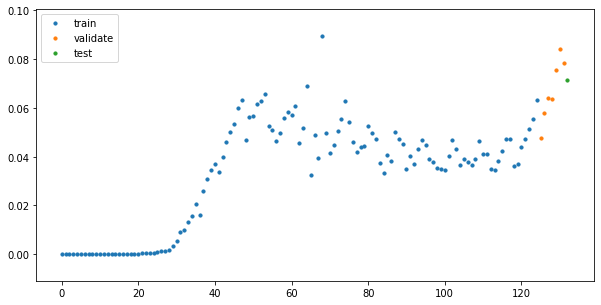

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.scatter(range(len(X)), X[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30,color='k')
ax.scatter(range(len(X_cnn_train)), X_cnn_train[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='train')
ax.scatter(range(len(X_cnn_train), len(X_cnn_train)+len(X_cnn_validate)), X_cnn_validate[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='validate')
ax.scatter(range(len(X_cnn_train)+len(X_cnn_validate), len(X)), X_cnn_test[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='test')
plt.legend()
_ = plt.show()

In [9]:
splits_3d = concatenate_4d_into_3d(scaled_splits)
(X_cnn_train_model, y_cnn_train_model, X_cnn_validate_model,
 y_cnn_validate_model, X_cnn_test_model, y_cnn_test_model) = splits_3d
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()

In [10]:
epochs_list = [50, 100, 200]
batch_size_list = [64, 256, 1024]
filter1_list = [16,32,64]
filter2_list = [2,4,8]
kernel1_size_list = [4,6,8]
kernel2_size_list = [4,6,8]

In [11]:
parameter_combinations = list(itertools.product(epochs_list, batch_size_list, filter1_list,
                                                filter2_list, kernel1_size_list, kernel2_size_list))

In order to both save the results as well as ensure that the run of this notebook can be broken up into sessions, create a DataFrame which logs the scores and saves them to a .csv file. During the exploration of hyperparameters, this csv will be overwritten with the inclusion of any new scores calculated. This will allow for comparison and analysis of the hyper parameter space, as well as ensure that we do not have to fit the model 729 times per run of this notebook. The scores that are saved are the ones generated by the validation set predictions. Also included for comparison purposes are the scores resulting from the naive baseline. 

In [12]:
if os.path.isfile('cnn_score_logging.csv'):
    score_logging_df = pd.read_csv('cnn_score_logging.csv', index_col=0)
else:
    score_logging_df = pd.DataFrame(np.array(parameter_combinations), 
                                    columns=['epochs','batch_size','filter_1','filter_2','kernel_1','kernel_2'])
    score_logging_df.loc[:, 'mean_squared_error'] = np.nan
    score_logging_df.loc[:, 'mean_absolute_error'] = np.nan
    score_logging_df.loc[:, 'explained_variance'] = np.nan
    score_logging_df.loc[:, 'naive_mean_absolute_error'] = np.nan
    score_logging_df.loc[:, 'naive_explained_variance'] = np.nan
    score_logging_df.loc[:, 'naive_mean_squared_error'] = np.nan

In [13]:
kernel0 = RandomNormal(seed=0)
kernel1 = RandomNormal(seed=1)
kernel2 = RandomNormal(seed=2)
kernel3 = RandomNormal(seed=3)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
score_logging_df.sample(5)

,epochs,batch_size,filter_1,filter_2,kernel_1,kernel_2,mean_squared_error,mean_absolute_error,explained_variance,naive_mean_absolute_error,naive_explained_variance,naive_mean_squared_error
253,100,64,16,4,4,6,278.091060,7.199402,0.920333,6.38194,0.915816,283.717052
597,200,256,32,2,6,4,NaN,NaN,NaN,NaN,NaN,NaN
430,100,1024,16,8,8,6,NaN,NaN,NaN,NaN,NaN,NaN
230,50,1024,64,4,6,8,296.195258,8.795685,0.920441,6.38194,0.915816,283.717052
519,200,64,32,2,8,4,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for i, hyper_parameters in enumerate(parameter_combinations):
    
    (epochs, batch_size, filter1, 
     filter2, kernel1_size, kernel2_size) = hyper_parameters
    
    if score_logging_df.isna().loc[i,'mean_squared_error']:
        cnn = Sequential()
        cnn.add(Conv1D(filters=int(filter1), kernel_size=int(kernel1_size),
                         padding='valid',
                         input_shape=X_cnn_train.shape[2:],
                         use_bias=False,
                        kernel_initializer=kernel0
                        )
                 )
        cnn.add(Conv1D(filters=int(filter2), 
                         kernel_size=int(kernel2_size), 
                         padding='valid',
                         use_bias=False,
                        kernel_initializer=kernel1
                        )
                 )
        cnn.add(Flatten())
        cnn.add(Dense(cnn.output.shape[1], 
                      kernel_initializer=kernel2
                       )
                 )
        cnn.add(Dense(1, 
                        activation='relu',
                      kernel_initializer=kernel3
                           ))
        cnn.compile(loss='mse', optimizer=Adam())
        history = cnn.fit(X_cnn_train_model, y_cnn_train_model, epochs=epochs, validation_data=(X_cnn_validate_model, y_cnn_validate_model), 
                  batch_size=batch_size, verbose=0)
        
        y_true = y_cnn_validate_model.ravel()
        y_predict = cnn.predict(X_cnn_validate_model).ravel()
        y_naive = y_validate_naive.ravel()

        score_logging_df.loc[i,'naive_mean_squared_error'] = mean_squared_error(y_true.ravel(), y_naive.ravel())
        score_logging_df.loc[i,'mean_squared_error']  = mean_squared_error(y_true.ravel(), y_predict)
        score_logging_df.loc[i,'naive_explained_variance']  = explained_variance_score(y_true.ravel(), y_naive.ravel())
        score_logging_df.loc[i,'explained_variance']  = explained_variance_score(y_true.ravel(), y_predict)
        score_logging_df.loc[i,'naive_mean_absolute_error']  = mean_absolute_error(y_true.ravel(), y_naive.ravel())
        score_logging_df.loc[i,'mean_absolute_error']  = mean_absolute_error(y_true.ravel(), y_predict)
        # every time a new score is calculated, overwrite the original file, to save space but also save progress scoring.
        score_logging_df.to_csv('cnn_score_logging.csv')
    else:
        pass
    
    print('#',end='')
    if (i % 50 == 0) & (i>0):
          print(' {} runs completed'.format(str(i)))



################################################### 50 runs completed
################################################## 100 runs completed
################################################## 150 runs completed
################################################## 200 runs completed
################################################## 250 runs completed
################################################## 300 runs completed
################################################## 350 runs completed
################################################## 400 runs completed
#########################

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py:61: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif not isinstance(value, collections.Sized):


######################### 450 runs completed
#####

In [ ]:
best_model_parameters = score_logging_df.loc[score_logging_df.mean_squared_error.idxmin(),:].iloc[:, :5]

In [ ]:
(epochs, batch_size, filter1, 
 filter2, kernel1_size, kernel2_size) = best_model_parameters

best_cnn = Sequential()
best_cnn.add(Conv1D(filters=int(filter1), kernel_size=int(kernel1_size),
                 padding='valid',
                 input_shape=X_cnn_train.shape[2:],
                 use_bias=False,
                kernel_initializer=kernel0
                )
         )
best_cnn.add(Conv1D(filters=int(filter2), 
                 kernel_size=int(kernel2_size), 
                 padding='valid',
                 use_bias=False,
                kernel_initializer=kernel1
                )
         )
best_cnn.add(Flatten())
best_cnn.add(Dense(best_cnn.output.shape[1], 
              kernel_initializer=kernel2
               )
         )
best_cnn.add(Dense(1, 
                activation='relu',
              kernel_initializer=kernel3
                   ))
best_cnn.compile(loss='mse', optimizer=Adam())
history = best_cnn.fit(X_cnn_train_model, y_cnn_train_model, epochs=epochs, validation_data=(X_cnn_validate_model, y_cnn_validate_model), 
          batch_size=batch_size, verbose=0)

In [ ]:
best_cnn.summary()

To ensure that we are not overtraining the CNN, let's look at the plots of validation loss and training loss as a function of the number of epochs.

In [ ]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

In [ ]:
_ = plt.plot(history.history['loss'][-100:], label='loss')
_ = plt.plot(history.history['val_loss'][-100:], label='val_loss')
_ = plt.legend()
_ = plt.show()

Overtraining would be signalled by the validation loss increasing while the training loss decreases; there does not seem to be substantial evidence for this so we can move onto the prediction results. As a "sanity check", predict the outcomes of the training data, to see whether or not the predictions perform better than the naive baseline; if not, then either something is wrong or the model is not worth pursuing.

In [ ]:
y_true = y_cnn_train_model.ravel()
y_predict = cnn.predict(X_cnn_train_model).ravel()
model_analysis(y_true, y_train_naive, y_predict, n_countries, title='CNN model', suptitle='Performance on training set')

Next, check the efficacy of the model by predicting the validation data. Note that this is different from the "testing" set, or hold-out set, which is used for the final check of the model. 

In [ ]:
y_true = y_cnn_validate_model.ravel()
y_predict = cnn.predict(X_cnn_validate_model).ravel()
model_analysis(y_true, y_validate_naive, y_predict, n_countries, title='CNN model', suptitle='Performance on validation set')

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(5,5),sharex=True)
(ax1,ax2,ax3,ax4) = axes.flatten()
_ = ax1.hist(best_cnn.get_weights()[0].ravel())
_ = ax2.hist(best_cnn.get_weights()[1].ravel())
_ = ax3.hist(best_cnn.get_weights()[2].ravel())
_ = ax4.hist(best_cnn.get_weights()[3].ravel())
plt.show()

future work

different baseline
more than 1-day step predictions. 
different time-frame or entire data set usages. 

By iterating over possible leading window dates (window right edge, not inclusive),
a 4-d tensor with dimensions given by the following is created:
    
```(n_windows, n_countries, n_time_steps, n_features)```

Even if I don't use the input of this form, it makes it much easier to slice into train, validate and test, by slicing along
the ```n_windows``` axis. 

Note that if I also only wanted to include data from after the first case, that is possible by slicing data.time_index >= 1 

Putting this all together:


Now, splitting X intro train, validate, test, is as easy as slicing the first axis. Depending on how the CNN is set up, this
axis can later be flattened by simply applying ```np.concatenate(X_train, axis=0)```

Now, for the target data ```y```. To be as general as possible, I note that I should first shift the time series and combine them to store all of the data, and THEN manipulate it, i.e.

Assuming that ```X``` is of the shape ```(n_windows, n_countries, n_time_steps, n_features)```, the target data ```y``` should
be of shape ```(n_windows, n_countries)``` and the values for each slice of the first axis is then of shape ```(n_countries,)```, with the values equaling the ```model_data.n_cases_weighted``` value for ```time_index == window_right_edge_inclusive + n```, where n is the prediction step size. 

Because we need future values with which to measure error, the maximum that the leading window edge can be is always 

```model_data.time_index.max() - n```

In other words, because the maximum date value is

If I want to predict (and measure error) for 7 days in the future, the last window would have leading edge 
```model_data.time_index == 123```. 

For now, just test the waters with a 1-day prediction.
To do so, first split the X and y data into train, validate, test.
For the first attempt at a model, use Conv1D only, have to flatten the data with concatenations.
Before this, however, I want to rescale the data. Now, because each different element in the first axis is a different time range, the correct action is to (if normalizing) take the mean with respect to axis=1 and axis=2 ```n_countries``` and  ```n_time_steps```. This leaves a total number of averages of shape ```(n_windows, n_features)```, i.e. the mean and standard deviations for each feature for each date range. This ensures that no data snooping has occurred. To actually subtract and divide by these values, need to reform the same shape array (or at least that seems to be the easiest method to me.

Just to check, the slice [0, :, :, 0] should only contain one value.

Need to normalize only using the values up until frame; in fact, I only use the values inside each frame to normalize.
In the case of normalizing the validation and testing sets, use the most recent frame's means and standard deviation to normalize. This requires forming the correctly shaped array which is performed using np.tile()

Unfortunately there are values (actually a single value) where the standard deviation equals 0. Luckily, this
can be circumvented because the value of $X-\bar{X}$ is zero in the same place; i.e. I set $\sigma=1$ at that location, because
it doesn't actually affect the value.

Notes on results

    1. kernel small->large seems to work ok.
    2. filters
    3. pooling seems to hurt.

Create a 5-d tensor for convolution and FC layer parameters using itertools.
The layers of the CNN will remain the same throughout testing for now. That is, 

    1. Conv1D(f1, k1)
    2. Conv1D(f2, k2)
    3. Flatten
    4. Dense(d)
    5. Dense(1)) 

I don't know enough yet, but my intuition tells me that the overall trend (macroscopic picture)
is much more important to capture than microscopic. 
   
    f1 : number of filters,  first convolutional layer
    k1 : kernel size, first convolutional layer
    f1 : number of filters,  second convolutional layer
    k1 : kernel size, second convolutional layer
    d : number of nodes in hidden fully connected layer
    

I believe the naive baseline is performing so much better simply because of the growth in number of new cases; i.e. the model is training on smaller values and so in every prediction its underestimating. It's also predicting nearly the same values for each separate validation date, likely indicative of overfitting. 

Changing the activations and the layers seems to work much better than the number of filters and kernel size.

ReLU activation on both cd layers somehow increases the values, i.e. away from zero? how does that make sense.
Predicting non-negative quantity -> ReLU at eachy layer, otherwise model will try to use negative values which never do anything?

On the surface this performs worse but doesn't look like it's making ***terrible*** predictions. I'll show that I believe
that the model is indeed over-fitting. 

Relation between X slicing and the original data: 

    X[-1, :, -1, 2] = model_data.time_index.max() - n_days_into_future 
    X[-t, :, -1, 2] = (model_data.time_index.max() - n_days_into_future + 1) - t


### Data Format

Now I will discuss the data format which I have found the most useful. The motivation behind this formatting is that is has to be compatible with keras' convolution layers, respect ordering in time and hopefully be easy to use.

A "sample" or single input of the convolutional model is to be a single time window which I shall refer to as a frame. The output of the model will be a single day's worth of predictions, namely, the next day's number of cases, (with some experimentation into the forecasting range to be performed later). The Conv1D layers require that each sample be of two dimensional input ```(n_time_steps, n_features)```, but the training / testing sets themselves are passed as 3-D tensors of shape ```(all_train_or_test_frames, n_time_steps, n_features)```. In order to partition time in an easy manner, it is easier to first create a 4-D tensor, whose (first) axis can be thought of as indexing the leading edge of the time frames. Therefore, slicing into training, validation and testing, is a well ordered operation simply performed by slicing the tensor along this axis. (picture) ```(n_frames, n_countries, n_time_steps, n_features)```. It is also relatively straight forward how to manipulate the target variables and 

In [ ]:
# print(X.shape) 
# print(y.shape)

In [ ]:
# t = (n_validation_frames + n_test_frames)
# new_cases_weighted_index=0
# ((np.exp(X[-t, :, -1, new_cases_weighted_index])-1) - data[data.time_index == ((data.time_index.max() - n_days_into_future + 1) - t)].new_cases_weighted).sum()

And so to test the baseline, the predictions are of course the date on the RHS + n_days_into_future, or 

This proves the case where n_validate_frames == 1. Now try it for 7. This means that the "first" validation frame is t==8

Ok. Now to see if the baseline is actually what I think it is. There could be an issue into how I am calculating the loss.
This is calculating the loss of all batch frames simulataneously...? Each frame for each country makes a single prediction.
Should I be trying to group it only by frame though? I.e. 2-d input. 

In [ ]:
# y_naive = X[-n_test_frames-1, :, -1,  new_cases_weighted_index]

In [ ]:
# y - create_Xy(model_data, start_date, frame_size, n_days_into_future, n_countries)[1][-y.shape[0]:]

Somehow the relation between X and y is upheld (because of for loop?) they are not changing between n_days_into_future_changes. 

Emulate the last iteration of for loop.

What should be going on. For n_days_into_future = 7, X should be slicing data from time <= 123

Then, the data is reshaped to be an iterable of sequences of length max_date_in_window, which is then truncated.

For y. What should be happening? 

X is made such that its maximum date is  ```model_data.time_index.max() - n_days_into_future```. So by the very creation of
X, X and y are already staggered if y is sliced correctly. Which would be ```start_date + n_days_into_future : ```, or simply ```-X.shape[0]:```

X_test is the last frame. meaning that it currently contains t-14 information. y_test is the very last day, n_cases_per_million
un-normalized, so the naive model would be simply to use y_predict = X_test_original[:, -1, 2], this takes the values of the feature, new_cases_per_million, on the last day of the frame, for all countries.

SeperableConv2D model. I believe that time steps should be channels and then countries should be the rows...

Suprisingly, my first guess at the parameters was very close to the optimal setup.

In [ ]:
# print('The top 10 sets of parameters (k1,k2,f1,f2,d) are:\n')

# mae_rankings = pd.DataFrame(np.concatenate((parameter_grid[mae_list.argsort()],mae_list[mae_list.argsort()].reshape(-1,1)),axis=1), 
#              columns=['kernel_layer_1','kernel_layer_2','filter_layer_1','filter_layer_2','MAE'])
# mae_rankings.head()


In [ ]:
# mae_rankings.to_csv('conv_parameter_rankings.csv')

# best_param_predictions = predictions_list[mae_list.argsort()][0]

# pd.DataFrame(predictions_list[mae_list.argsort()]).to_csv('model_param_grid_predictions.csv')

In [ ]:
# pd.read_csv('conv_parameter_rankings.csv', index_col=0)

Because ```n_days_into_future == 1```, The most recent date in the last frame of X is data.time_index.max()-1.
The maximum date in y is data.time_index().max(). Therefore, to convert, we have
    
    X[-1,:,-1,:] = y[-2, :]
    
or, more generally, 

    X[-t,:,-1,:] = y[-(n+t), :]
    
testing this:

In [ ]:
# last_day_in_X = -1
# if last_day_in_X == -1:
#     last_day_in_X = None
# X_test_original = X[-16:last_day_in_X, :, -1, new_cases_weighted_index] 
# if last_day_in_X is None:
#     last_day_in_X = 0

# X_test_original - y[-(n_test_frames+n_days_into_future+X_test_original.shape[0]+last_day_in_X-1):
#                     -(n_days_into_future+last_day_in_X), :]

This shows that the staggering has been done correctly. That is, each entry along the first axis of X predicts.
Need to make sure that the naive predictions are being chosen correctly. To do so, just look at the instance
where n_frames_validation == 1 and n_frames_test == 1 (to make slicing easier) for n_days_into_future == 7.

Specifically, the shifting and comparison between y_validate and X_train isn't so hard as it follows the above formula.
This is prior to concatenation / squeezing / flattening the first axis.

    The following holds but this is not the predictions relation:   X[-t,:,-1,:] = y[-(n+t), :]
                                                  
    y has already been shifted to account for the n_days_into_future prediction. Therefore,     
    True future new_cases_weighted values : y[-t,:]. This is the n_days_into_future values.
    
    CNN predictions new_cases_weighted : model.predict(X[-t, :, :, :]). This predicts using the "present day" frame. 
    
    Naive predictions new_cases_weighted values: X[-t,:,-1, 2]. This takes the present day value from the last values of the frames.

Therefore, when n_validation_frames > 1.  are simply

    Naive predictions = X[validation_indices, :, -1, 2]
    CNN predictions = model.predict(X[validation_indices, :, :, :])
    True future values = y[validation_indices, :]
    
    Where validation indices is assumed to be a correctly formatted array of negative indices. 
    
    
    The last issue is the fact that X_validate is normalized and y values are not. Therefore, for the prediction X_validate is used, but for the naive baseline either the inverse normalized X_validation or just the original X should be used. Original
    X is actually easier because of 4-d index.

First, train and "test" without using the holdout test set. i.e. just use train and validation sets to test
This uses a single frame to validate (and test). Therefore, the naive model is formed by taking the frame of
X_validate and using its values for the prediction. The true values are stored in y_validate, the predicted values
are formed by using X_validate to predict, the naive values are the values in X_validate. 

Remember when slicing, the n_days_into_future buffer has already been factored into account. i.e. test
slicing is X[-n_test_frames:,:,:,:]

X time_index 130 is not used. X_test is 129, y_test is 130. X_validate is 126,127,128 y is 127,128,129.

In [ ]:
# np.sqrt(1./(X_train.shape[0]/32))

from https://papers.nips.cc/paper/7320-how-many-samples-are-needed-to-estimate-a-convolutional-neural-network.pdf

To achieve error $\epsilon$ with filter number $m$ the number of samples needed is $\mathcal{O}(m/\epsilon^2)$

Let $\epsilon = 0.1$, then $100m$ = samples or $m = samples/100$. The number of samples is

It seems that included information from the too distant past actually makes the model worse. 

switching the order of countries and timesteps affects the following:
reshape A
kernel size B
kernal size AB
concatenate axis 1->2

If you have a convolution model. How is choosing a smaller frame size + kernel size different from
larger

The above model is the *only* one that hasn't underestimated values. There is still a lot of parameter tuning to be completed though:

The performance is the same up to small differences attributable to the individual trainings. 

In both models, the key difference between the predictions and the true values is that the ConvNet is having a hard
time picking up on dramatic spikes in the number of new cases. 